* https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html
* https://www.pyimagesearch.com/2017/04/10/detect-eyes-nose-lips-jaw-dlib-opencv-python/

# 1. Face Elements Location Detection

In [1]:
from collections import OrderedDict
import numpy as np
import cv2
import argparse
import dlib
import imutils
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import dlib
def get_frontal_face(image):
    face_detector = dlib.get_frontal_face_detector()
    try:
        faces = face_detector(image)
    except:
        return []
    if len(faces)>1:
        size_list = []
        for face in faces:
            size = (face.bottom()-face.top())*(face.right()-face.left())
            size_list.append(size)
        face = faces[np.argmax(size_list)]
    elif len(faces)==1:
        face = faces[0]
    else:
        return []

    front_face = image[face.top():face.bottom(),face.left():face.right()]
    if 0 in front_face.shape:
        return []
    front_face = cv2.resize(front_face, dsize=(200,200))
    front_face = cv2.cvtColor(front_face.astype('uint8'), cv2.COLOR_BGR2RGB)
    return front_face

In [3]:
facial_features_cordinates = {}

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions
FACIAL_LANDMARKS_INDEXES = OrderedDict([
    ("Mouth", (48, 68)),
    ("Right_Eyebrow", (17, 22)),
    ("Left_Eyebrow", (22, 27)),
    ("Right_Eye", (36, 42)),
    ("Left_Eye", (42, 48)),
    ("Nose", (27, 35)),
    ("Jaw", (0, 17))
])

In [4]:
def visualize_facial_landmarks(image, shape, colors=None, alpha=0.75):
    # create two copies of the input image -- one for the
    # overlay and one for the final output image
    overlay = image.copy()
    output = image.copy()

    # if the colors list is None, initialize it with a unique
    # color for each facial landmark region
    if colors is None:
        colors = [(19, 199, 109), (79, 76, 240), (230, 159, 23),
                  (168, 100, 168), (158, 163, 32),
                  (163, 38, 32), (180, 42, 220)]

    # loop over the facial landmark regions individually
    for (i, name) in enumerate(FACIAL_LANDMARKS_INDEXES.keys()):
        # grab the (x, y)-coordinates associated with the
        # face landmark
        (j, k) = FACIAL_LANDMARKS_INDEXES[name]
        pts = shape[j:k]
        facial_features_cordinates[name] = pts

        # check if are supposed to draw the jawline
        if name == "Jaw":
            # since the jawline is a non-enclosed facial region,
            # just draw lines between the (x, y)-coordinates
            for l in range(1, len(pts)):
                ptA = tuple(pts[l - 1])
                ptB = tuple(pts[l])
                cv2.line(overlay, ptA, ptB, colors[i], 2)

        # otherwise, compute the convex hull of the facial
        # landmark coordinates points and display it
        else:
            hull = cv2.convexHull(pts)
            cv2.drawContours(overlay, [hull], -1, colors[i], -1)

    # apply the transparent overlay
    cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

    # return the output image
    return output,facial_features_cordinates

In [5]:
def shape_to_numpy_array(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coordinates = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coordinates[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coordinates

In [27]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# 2. Load images

In [6]:
root_dir = '/home/dxlab/jupyter/soyoung/racist_model/racialData'
citizen_test = np.load(root_dir+'/test_set/test_citizen_white_to_black/img_path.npy')
mugshot_test = np.load(root_dir+'/test_set/test_mugshot_black_to_white/img_path.npy')

frontal_ctz_dir = '/frontal_face_set/citizen'
frontal_mgs_dir = '/frontal_face_set/mugshot'

citizen_test = list(citizen_test)
for i in range(len(citizen_test)):
    citizen_test[i] = frontal_ctz_dir+'/'+citizen_test[i]
    
mugshot_test = list(mugshot_test)
for i in range(len(mugshot_test)):
    mugshot_test[i] = frontal_mgs_dir+'/'+mugshot_test[i]+'.jpg'    

In [7]:
#for same directory name
for i,ctz in enumerate(citizen_test):
    if len((ctz.split('/')[3]).split('.')[0])<6:
        citizen_test[i] = root_dir+'/citizen2/train/' + ctz.split('/')[3]
    else:
        citizen_test[i] = root_dir+'/citizen/' + ctz.split('/')[3]

# 3. Change Nose, Lip, Skin tone -> Citizen White to Black

In [8]:
from skin.skinDetection import change_skin
from skin.noFaceSkinDetection import obtain_skin_color
from skin.faceDetection import get_skin_color

In [9]:
#white, black average skin rgb value
white_skin = (255,226,214)
black_skin =  (79,48,25) #b g r

In [10]:
#change skin tone

def skin_tone_change(path, color):
    changed = change_skin(path, color , '')
    if len(changed) == 0:
        return []

    image = Image.open(io.BytesIO(changed))
    temp = image.resize((200,200))

    original = Image.open(path)
    original = original.resize((200,200))

    if image==None:
        return []

    #if nothig changed
    if np.sum(np.array(original)-np.array(temp))==0: 
        return []
    
    return np.array(image)

In [11]:
def white_to_black_nose(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        return []
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = shape_to_numpy_array(shape)

        output,facial_features_cordinates = visualize_facial_landmarks(image, shape)

    im = image.copy()
  
    # 1. widen nose
    nose = facial_features_cordinates['Nose']
    x1 = np.min(nose[:,0])
    x2 = np.max(nose[:,0])
    y1 = np.min(nose[:,1])
    y2 = np.max(nose[:,1])
    x1-=8
    x2+=8
    y1+=15
    

    roi = im[y1:y2, x1:x2]
    
    if len(roi) == 0:
        x1+=8
        x2-=8
        y1-=15
        roi = im[y1:y2, x1:x2]
        if len(roi) == 0:
            return []
    
    resize_roi = cv2.resize(roi, None, fx = 1.5, fy = 1, interpolation = cv2.INTER_CUBIC) #indentation wrong
    
    newimg_res = im.copy()
    center_x = (x1 + x2)  /2
    center_y = (y1 + y2)  /2
    new_nose_half_w = resize_roi.shape[1] / 2
    newimg_res[y1:y2, int(center_x-new_nose_half_w):int(center_x+new_nose_half_w)] = resize_roi
    
    # 2. blur appended part
    appended_l = newimg_res[y1:y2, int(center_x-new_nose_half_w)-5:int(center_x-new_nose_half_w)+3].copy()
    appended_r = newimg_res[y1:y2, int(center_x+new_nose_half_w)-3:int(center_x+new_nose_half_w)+5].copy()
    if len(appended_l)==0 or len(appended_r)==0:
        return []

    try:
        for i in range(5):
            appended_l = cv2.GaussianBlur(appended_l, (5,5), 0)
            appended_r = cv2.GaussianBlur(appended_r, (5,5), 0)
    except:
        return []

    newimg_res[y1:y2, int(center_x-new_nose_half_w)-5:int(center_x-new_nose_half_w)+3] = appended_l
    newimg_res[y1:y2, int(center_x+new_nose_half_w)-3:int(center_x+new_nose_half_w)+5] = appended_r

    
    kernel_sharpen_1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    
    # 3. blur whole part
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    
    # 4. image sharpening
    newimg_res = cv2.filter2D(newimg_res,-1,kernel_sharpen_1)
    newimg_res = cv2.cvtColor(newimg_res.astype('uint8'), cv2.COLOR_BGR2RGB)
    
    return newimg_res

In [12]:
def white_to_black_lip(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        return []
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = shape_to_numpy_array(shape)

        output,facial_features_cordinates = visualize_facial_landmarks(image, shape)

    im = image.copy()
    
    # 1. widen lip
    Mouth = facial_features_cordinates['Mouth']
    x_min = np.min(Mouth[:,0])
    x_max = np.max(Mouth[:,0])
    y_min = np.min(Mouth[:,1])
    y_max = np.max(Mouth[:,1])
    
    lip = im[y_min:y_max, x_min:x_max]
    resize_lip = cv2.resize(lip, None, fx = 1.2, fy = 1.6, interpolation = cv2.INTER_CUBIC) #indentation wrong
    newimg_res = im.copy()
    center_x = (x_min + x_max)  /2
    center_y = (y_min + y_max)  /2
    new_lip_half_h = resize_lip.shape[0] / 2
    new_lip_half_w = resize_lip.shape[1] / 2

    newimg_res[int(center_y-new_lip_half_h):int(center_y+new_lip_half_h),int(center_x-new_lip_half_w):int(center_x+new_lip_half_w)] = resize_lip
    
    # 2. blur appended part
    appended_u = newimg_res[int(center_y-new_lip_half_h)-5:int(center_y-new_lip_half_h)+3,int(center_x-new_lip_half_w)-5:int(center_x+new_lip_half_w)+3 ].copy()
    appended_d = newimg_res[int(center_y+new_lip_half_h)-3:int(center_y+new_lip_half_h)+5,int(center_x-new_lip_half_w)-3:int(center_x+new_lip_half_w)+5 ].copy()

    for i in range(5):
        appended_u = cv2.GaussianBlur(appended_u, (3,3), 0)
        appended_d = cv2.GaussianBlur(appended_d, (3,3), 0)

    newimg_res[int(center_y-new_lip_half_h)-5:int(center_y-new_lip_half_h)+3,int(center_x-new_lip_half_w)-5:int(center_x+new_lip_half_w)+3] = appended_u
    newimg_res[int(center_y+new_lip_half_h)-3:int(center_y+new_lip_half_h)+5,int(center_x-new_lip_half_w)-3:int(center_x+new_lip_half_w)+5] = appended_d
    
    kernel_sharpen_1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])
    
    # 3. blur whole part
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    newimg_res = cv2.GaussianBlur(newimg_res,(5,5),0)
    
    # 4. image sharpening
    newimg_res = cv2.filter2D(newimg_res,-1,kernel_sharpen_1)
    newimg_res = cv2.cvtColor(newimg_res.astype('uint8'), cv2.COLOR_BGR2RGB)

    return newimg_res

# 3-1. Change Skin tone -> Citizen White to Black

In [13]:
from tqdm.notebook import tqdm
import io

In [26]:
#change skin tone to black -> crop face

ctz_skin_changed = []
ctz_skin_name = []

for img in tqdm(citizen_test):
    try:
#         skin tone change to black
        skin_chg_img = skin_tone_change(img, black_skin)
    except:
        continue
    if len(skin_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(skin_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    ctz_skin_changed.append(cropped)
    ctz_skin_name.append(img)

In [99]:
ctz_skin_changed = np.array(ctz_skin_changed)
ctz_skin_name = np.array(ctz_skin_name)
ctz_skin_changed.shape, ctz_skin_name.shape

((1287, 200, 200, 3), (1287,))

In [29]:
np.save('./features_changed/ctz_blacked/ctz_skin_changed.npy', ctz_skin_changed)
np.save('./features_changed/ctz_blacked/ctz_skin_used_name.npy', ctz_skin_name)

In [8]:
ctz_skin_changed = np.load('./features_changed/ctz_blacked/ctz_skin_changed.npy')
ctz_skin_name = np.load('./features_changed/ctz_blacked/ctz_skin_used_name.npy')

In [15]:
# nothing changed or images that have to be removed
x = '1 4 5 13 16 18 22 24 31 34 37 50 52 56 63 68 80 85 91 95 101 102 105 114 123 126 127 130 134 135 139 147 152 155 160 162 168 171 173 181 184 187 199 201 203 207 217 222 224 226 230 235 236 237 245 247 249 250 255 261 266 269 276 284 286 287 289 293 295 296 297 299 303 304 314 318 323 324 330 331 332 338 341 344 345 348 355 356 357 361 370 372 374 376 381 387 389 392 394 396 399 410 411 415 416 417 418 419 423 424 431 432 437 439 443 447 451 454 460 461 462 465 466 469 470 475 476 484 486 487 489 492 495 498 499 505 510 511 512 513 518 519 523 531 534 536 538 541 545 551 555 559 561 563 566 570 574 577 579 581 589 591 592 596 598 600 602 604 605 606 611 617 620 622 623 625 629 632 634 639 640 641 642 645 646 651 655 657 660 661 662 670 671 677 679 685 688 691 697 705 710 711 713 721 728 729 732 733 738 743 746 749 752 756 757 758 760 761 762 765 768 769 771 772 774 779 780 785 787 789 794 795 801 805 809 811 812 822 825 827 832 833 834 835 839 840 841 842 844 847 850 852 855 859 860 861 862 866 869 870 872 873 875 881 882 883 884 885 886 888 892 893 895 898 899 903 904 911 913 917 919 922 923 924 925 927 928 930 931 933 937 943 944 945 952 954 958 959 961 962 970 972 973 977 979 981 982 983 989 991 992 993 994 995 997 998 1001 1006 1012 1015 1019 1021 1023 1027 1028 1029 1036 1039 1041 1042 1045 1051 1052 1054 1056 1058 1059 1061 1062 1063 1068 1070 1073 1074 1077 1078 1080 1082 1084 1087 1089 1090 1092 1093 1097 1099 1104 1106 1110 1114 1115 1117 1120 1122 1126 1127 1128 1130 1135 1136 1137 1141 1143 1146 1148 1149 1151 1153 1154 1155 1158 1159 1161 1164 1167 1170 1171 1177 1180 1183 1187 1191 1192 1194 1195 1196 1201 1202 1206 1207 1209 1213 1216 1218 1222 1223 1224 1225 1231 1232 1233 1240 1242 1253 1258 1263 1265 1266 1271 1277 1278 1279 1281 1284 1285'

In [22]:
no_face_idx = np.array(x.split(' ')).astype('int')

In [26]:
ctz_skin_changed_2 = []
ctz_skin_name_2 = []
for i in tqdm(range(len(ctz_skin_changed))):
    if i not in no_face_idx:
        ctz_skin_changed_2.append(ctz_skin_changed[i])
        ctz_skin_name_2.append(ctz_skin_name[i])

In [51]:
np.save('./features_changed/ctz_blacked/ctz_skin_changed_2.npy', ctz_skin_changed_2)
np.save('./features_changed/ctz_blacked/ctz_skin_name_2.npy', ctz_skin_name_2)

In [130]:
ctz_skin_changed_2 = np.load('./features_changed/ctz_blacked/ctz_skin_changed_2.npy')
ctz_skin_name_2 = np.load('./features_changed/ctz_blacked/ctz_skin_name_2.npy')

# 3-2. Change Nose shape -> Citizen White to Black

In [5]:
#change nose shape like black -> crop face

ctz_nose_changed = []
ctz_nose_name = []

for img in tqdm(ctz_skin_name_2):
#     try:
# #         skin tone change to black
    image = cv2.imread(img)
    nose_chg_img = white_to_black_nose(image)
#     except:
#         continue
    if len(nose_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(nose_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    ctz_nose_changed.append(cropped)
    ctz_nose_name.append(img)

In [91]:
ctz_nose_changed = np.array(ctz_nose_changed)
ctz_nose_name = np.array(ctz_nose_name)
ctz_nose_changed.shape, ctz_nose_name.shape

((856, 200, 200, 3), (856,))

In [90]:
np.save('./features_changed/ctz_blacked/ctz_nose_changed.npy', ctz_nose_changed)
np.save('./features_changed/ctz_blacked/ctz_nose_used_name.npy', ctz_nose_name)

In [110]:
# nothing changed or images that have to be removed
x = '5 223 224 235 348 424 433 719'

In [111]:
no_face_idx_2 = np.array(x.split(' ')).astype('int')
ctz_nose_changed_2 = []
ctz_nose_name_2 = []
for i in tqdm(range(len(ctz_nose_changed))):
    if i not in no_face_idx_2:
        ctz_nose_changed_2.append(ctz_nose_changed[i])
        ctz_nose_name_2.append(ctz_nose_name[i])

In [117]:
np.save('./features_changed/ctz_blacked/ctz_nose_changed_2.npy', ctz_nose_changed_2)
np.save('./features_changed/ctz_blacked/ctz_nose_name_2.npy', ctz_nose_name_2)

In [129]:
ctz_nose_changed_2 = np.load('./features_changed/ctz_blacked/ctz_nose_changed_2.npy')
ctz_nose_name_2 = np.load('./features_changed/ctz_blacked/ctz_nose_name_2.npy')

# 3-3. Change Lip shape -> Citizen White to Black

In [87]:
#change lip shape like black -> crop face

ctz_lip_changed = []
ctz_lip_name = []

for img in tqdm(ctz_skin_name_2):
#     try:
# #         skin tone change to black
    image = cv2.imread(img)
    lip_chg_img = white_to_black_lip(image)
#     except:
#         continue
    if len(lip_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(lip_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    ctz_lip_changed.append(cropped)
    ctz_lip_name.append(img)

In [88]:
ctz_lip_changed = np.array(ctz_lip_changed)
ctz_lip_name = np.array(ctz_lip_name)
ctz_lip_changed.shape, ctz_lip_name.shape

((859, 200, 200, 3), (859,))

In [89]:
np.save('./features_changed/ctz_blacked/ctz_lip_changed.npy', ctz_lip_changed)
np.save('./features_changed/ctz_blacked/ctz_lip_used_name.npy', ctz_lip_name)

In [129]:
x = '10 25 125 426 578'
no_face_idx_3 = np.array(x.split(' ')).astype('int')
ctz_lip_changed_2 = []
ctz_lip_name_2 = []
for i in tqdm(range(len(ctz_lip_changed))):
    if i not in no_face_idx_3:
        ctz_lip_changed_2.append(ctz_lip_changed[i])
        ctz_lip_name_2.append(ctz_lip_name[i])

In [133]:
np.save('./features_changed/ctz_blacked/ctz_lip_changed_2.npy', ctz_lip_changed_2)
np.save('./features_changed/ctz_blacked/ctz_lip_name_2.npy', ctz_lip_name_2)

In [128]:
ctz_lip_changed_2 = np.load('./features_changed/ctz_blacked/ctz_lip_changed_2.npy')
ctz_lip_name_2 = np.load('./features_changed/ctz_blacked/ctz_lip_name_2.npy')

# 3-4. Change Skin, Nose, Lip -> Citizen White to Black

In [64]:
ctz_skin_changed = np.load('./features_changed/ctz_blacked/ctz_skin_changed.npy')
ctz_skin_name = np.load('./features_changed/ctz_blacked/ctz_skin_used_name.npy')

In [81]:
ctz_total_changed = []
ctz_total_name = []

for img in tqdm(ctz_skin_name):
    try:
#         skin tone change to black
        skin_chg_img = skin_tone_change(img, black_skin)
    except:
        continue
        
    if len(skin_chg_img)==0:
        continue
    
    #change nose
    nose_chg_img = white_to_black_nose(skin_chg_img)
#     except:
#         continue
    if len(nose_chg_img)==0:
        continue
        
    #change lip
    lip_chg_img = white_to_black_lip(nose_chg_img)
#     except:
#         continue
    if len(lip_chg_img)==0:
        continue
    
    try:
        
        cropped = get_frontal_face(lip_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    ctz_total_changed.append(cropped)
    ctz_total_name.append(img)

In [82]:
ctz_total_changed = np.array(ctz_total_changed)
ctz_total_name = np.array(ctz_total_name)
ctz_total_changed.shape, ctz_total_name.shape

((1070, 200, 200, 3), (1070,))

In [83]:
np.save('./features_changed/ctz_blacked/ctz_total_changed.npy', ctz_total_changed)
np.save('./features_changed/ctz_blacked/ctz_total_used_name.npy', ctz_total_name)

In [88]:
#images that have to be removed
x = '1 11 17 19 26 28 33 39 54 76 97 104 107 110 113 146 154 171 178 181 185 186 188 207 218 223 226 233 247 259 263 275 276 282 288 303 310 312 320 326 333 347 352 353 365 369 391 403 415 426 432 454 460 478 481 499 507 536 538 541 570 573 586 601 615 624 633 643 650 657 661 674 675 683 696 698 701 704 721 733 737 754 760 762 775 777 782 793 813 820 822 824 827 845 850 872 874 880 883 889 904 907 930 932 943 952 954 955 959 965 979 999 1005 1008 1013 1014 1015 1028 1030 1041 1046 1052 1053 1064 1068'
no_face_idx = np.array(x.split(' ')).astype('int')
ctz_total_changed_2 = []
ctz_total_name_2 = []
for i in tqdm(range(len(ctz_total_changed))):
    if i not in no_face_idx:
        ctz_total_changed_2.append(ctz_total_changed[i])
        ctz_total_name_2.append(ctz_total_name[i])

In [89]:
ctz_total_changed_2 = np.array(ctz_total_changed_2)
ctz_total_name_2 = np.array(ctz_total_name_2)
ctz_total_changed_2.shape, ctz_total_name_2.shape

((945, 200, 200, 3), (945,))

In [131]:
#we are going to use images included in 3 changed test set
ctz_name_final = set(ctz_skin_name_2) & set(ctz_nose_name_2) & set(ctz_lip_name_2) &set(ctz_total_name_2)

In [133]:
ctz_name_final = random.sample(list(ctz_name_final), 700)

In [135]:
ctz_skin_changed_3 = []
ctz_skin_name_3 = []

for i, img in enumerate(ctz_skin_name_2):
    if img in ctz_name_final:
        ctz_skin_changed_3.append(ctz_skin_changed_2[i])
        ctz_skin_name_3.append(img)

In [136]:
ctz_nose_changed_3 = []
ctz_nose_name_3 = []

for i, img in enumerate(ctz_nose_name_2):
    if img in ctz_name_final:
        ctz_nose_changed_3.append(ctz_nose_changed_2[i])
        ctz_nose_name_3.append(img)

In [139]:
ctz_lip_changed_3 = []
ctz_lip_name_3 = []

for i, img in enumerate(ctz_lip_name_2):
    if img in ctz_name_final:
        ctz_lip_changed_3.append(ctz_lip_changed_2[i])
        ctz_lip_name_3.append(img)

In [140]:
ctz_total_changed_3 = []
ctz_total_name_3 = []

for i, img in enumerate(ctz_total_name_2):
    if img in ctz_name_final:
        ctz_total_changed_3.append(ctz_total_changed_2[i])
        ctz_total_name_3.append(img)

In [141]:
len(ctz_skin_changed_3), len(ctz_nose_changed_3), len(ctz_lip_changed_3), len(ctz_total_changed_3)

(700, 700, 700, 700)

In [143]:
np.save('./features_changed/ctz_blacked/ctz_skin_changed_3_1.npy', np.array(ctz_skin_changed_3))
np.save('./features_changed/ctz_blacked/ctz_skin_name_3_1.npy', np.array(ctz_skin_name_3))

np.save('./features_changed/ctz_blacked/ctz_nose_changed_3_1.npy', np.array(ctz_nose_changed_3))
np.save('./features_changed/ctz_blacked/ctz_nose_name_3_1.npy', np.array(ctz_nose_name_3))

np.save('./features_changed/ctz_blacked/ctz_lip_changed_3_1.npy', np.array(ctz_lip_changed_3))
np.save('./features_changed/ctz_blacked/ctz_lip_name_3_1.npy', np.array(ctz_lip_name_3))

np.save('./features_changed/ctz_blacked/ctz_total_changed_3_1.npy', np.array(ctz_total_changed_3))
np.save('./features_changed/ctz_blacked/ctz_total_name_3_1.npy', np.array(ctz_total_name_3))

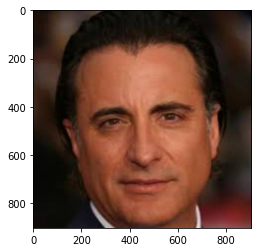

In [95]:
image = Image.open(img_name[900])
plt.imshow(image)

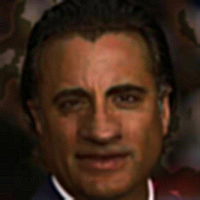

In [93]:
Image.fromarray(changed[900].astype('uint8'), 'RGB')

# 4. Change Nose, Lip, Skin tone -> Mugshot Black to White

In [14]:
#for same directory name
for i,mgs in enumerate(mugshot_test):
    mugshot_test[i] = root_dir + '/mugshot/front/front/' + mgs.split('/')[3]

In [23]:
def black_to_white_nose(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        return []
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = shape_to_numpy_array(shape)

        output,facial_features_cordinates = visualize_facial_landmarks(image, shape)

    im = image.copy()
  
    # 1. narrow nose
    nose = facial_features_cordinates['Nose']
    x1 = np.min(nose[:,0])
    x2 = np.max(nose[:,0])
    y1 = np.min(nose[:,1])
    y2 = np.max(nose[:,1])
    
    nose_part = im[:,x1:x2]
    new_nose = cv2.resize(nose_part, None, fx = 0.5, fy = 1, interpolation = cv2.INTER_CUBIC) 

    
    whited = np.concatenate((im[:,:x1], new_nose, + im[:,x2:]), axis=1)
    
    return whited

In [22]:
def black_to_white_lip(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        return []
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = shape_to_numpy_array(shape)

        output,facial_features_cordinates = visualize_facial_landmarks(image, shape)

    im = image.copy()
    
    # 1. narrow lip
    Mouth = facial_features_cordinates['Mouth']
    x_min = np.min(Mouth[:,0])
    x_max = np.max(Mouth[:,0])
    y_min = np.min(Mouth[:,1])
    y_max = np.max(Mouth[:,1])
    
    lip_part = im[y_min:y_max, :]
    new_lip = cv2.resize(lip_part, None, fx = 1, fy = 0.6, interpolation = cv2.INTER_CUBIC) 
    
    whited = np.concatenate((im[:y_min,:], new_lip, + im[y_max:,:]), axis=0)
    
    return whited

In [20]:
#change both nose and lip
def black_to_white(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)
    if len(rects)==0:
        return []
    
    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray, rect)
        shape = shape_to_numpy_array(shape)

        output,facial_features_cordinates = visualize_facial_landmarks(image, shape)

    im = image.copy()
  
    # 1. narrow nose
    nose = facial_features_cordinates['Nose']
    x1 = np.min(nose[:,0])
    x2 = np.max(nose[:,0])
    y1 = np.min(nose[:,1])
    y2 = np.max(nose[:,1])
    
    nose_part = im[:,x1:x2]
    new_nose = cv2.resize(nose_part, None, fx = 0.5, fy = 1, interpolation = cv2.INTER_CUBIC) 
    
    narrowed_nose = np.concatenate((im[:,:x1], new_nose, + im[:,x2:]), axis=1)
    
    # 2. narrow lip
    Mouth = facial_features_cordinates['Mouth']
    x_min = np.min(Mouth[:,0])
    x_max = np.max(Mouth[:,0])
    y_min = np.min(Mouth[:,1])
    y_max = np.max(Mouth[:,1])
    
    lip_part = narrowed_nose[y_min:y_max, :]
    new_lip = cv2.resize(lip_part, None, fx = 1, fy = 0.6, interpolation = cv2.INTER_CUBIC) 
    
    whited = np.concatenate((narrowed_nose[:y_min,:], new_lip, + narrowed_nose[y_max:,:]), axis=0)
    
    return whited

In [102]:
changed = []
img_name = []

for img in tqdm(mugshot_test):
    try:
        skin_chg_img = skin_tone_change(img, white_skin)
    except:
        continue
    if len(skin_chg_img)==0:
        continue
    whited = black_to_white(skin_chg_img)
    if len(whited)==0:
        continue
    changed.append(whited)
    img_name.append(img)
changed = np.delete(changed, (0,0), axis=0)

# 4-1. Change Skin tone -> Mugshot Black to White

In [155]:
#change skin tone to white -> crop face

mgs_skin_changed = []
mgs_skin_name = []

for img in tqdm(mugshot_test):
    try:
#         skin tone change to white
        skin_chg_img = skin_tone_change(img, white_skin)
    except:
        continue
    if len(skin_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(skin_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    mgs_skin_changed.append(cropped)
    mgs_skin_name.append(img)

In [156]:
mgs_skin_changed = np.array(mgs_skin_changed)
mgs_skin_name = np.array(mgs_skin_name)
mgs_skin_changed.shape, mgs_skin_name.shape

((1137, 200, 200, 3), (1137,))

In [9]:
x = '2 57 58 67 163 169 177 178 244 246 252 256 259 266 269 282 283 297 299 309 342 356 404 441 470 477 480 482 484 494 496 498 499 507 508 520 524 534 538 556 589 597 598 634 660 690 703 715 721 722 727 744 753 765 779 781 791 808 820 828 850 865 885 888 909 913 926 946 973 974 1017 1018 1029 1043 1074 1086 1106 1114 1126 1127 1134'

In [14]:
no_face_idx = np.array(x.split(' ')).astype('int')

mgs_skin_changed_2 = []
mgs_skin_name_2 = []
for i in tqdm(range(len(mgs_skin_changed))):
    if i not in no_face_idx:
        mgs_skin_changed_2.append(mgs_skin_changed[i])
        mgs_skin_name_2.append(mgs_skin_name[i])

# 4-2. Change Nose shape -> Mugshot Black to White

In [38]:
#change nose shape like white -> crop face

mgs_nose_changed = []
mgs_nose_name = []

for img in tqdm(mgs_skin_name_2):
    image = cv2.imread(img)
    nose_chg_img = black_to_white_nose(image)
#     except:
#         continue
    if len(nose_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(nose_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
#     cropped = cv2.cvtColor(cropped.astype('uint8'), cv2.COLOR_BGR2RGB)
    mgs_nose_changed.append(cropped)
    mgs_nose_name.append(img)

In [39]:
mgs_nose_changed = np.array(mgs_nose_changed)
mgs_nose_name = np.array(mgs_nose_name)
mgs_nose_changed.shape, mgs_nose_name.shape

((1054, 200, 200, 3), (1054,))

# 4-3. Change Lip shape -> Mugshot Black to White

In [61]:
#change lip shape like black -> crop face

mgs_lip_changed = []
mgs_lip_name = []

for img in tqdm(mgs_skin_name_2):
#     try:
# #         skin tone change to black
    image = cv2.imread(img)
    lip_chg_img = black_to_white_lip(image)
#     except:
#         continue
    if len(lip_chg_img)==0:
        continue
    
    try:
        cropped = get_frontal_face(lip_chg_img)
    except:
        continue
    if len(cropped)==0:
        continue
    cropped = cv2.cvtColor(cropped.astype('uint8'), cv2.COLOR_BGR2RGB)
    mgs_lip_changed.append(cropped)
    mgs_lip_name.append(img)

In [62]:
mgs_lip_changed = np.array(mgs_lip_changed)
mgs_lip_name = np.array(mgs_lip_name)
mgs_lip_changed.shape, mgs_lip_name.shape

((1053, 200, 200, 3), (1053,))

# 4-4. Change Skin, Nose, Lip -> Mugshot Black to White

In [46]:
mgs_skin_changed = np.load('./features_changed/mgs_whited/mgs_skin_changed.npy')
mgs_skin_name = np.load('./features_changed/mgs_whited/mgs_skin_used_name.npy')

In [114]:
mgs_total_changed = []
mgs_total_name = []

for img in tqdm(mgs_skin_name):
    try:
#         skin tone change to black
        skin_chg_img = skin_tone_change(img, white_skin)
    except:
        continue
        
    if len(skin_chg_img)==0:
        continue
    
    #change nose & lip
    changed = black_to_white(skin_chg_img)
#     except:
#         continue
    if len(changed)==0:
        continue

    try:
        cropped = get_frontal_face(changed)
    except:
        continue
    if len(cropped)==0:
        continue
    mgs_total_changed.append(cropped)
    mgs_total_name.append(img)

In [115]:
mgs_total_changed = np.array(mgs_total_changed)
mgs_total_name = np.array(mgs_total_name)
mgs_total_changed.shape, mgs_total_name.shape

((1122, 200, 200, 3), (1122,))

In [117]:
x = '2 57 63 66 159 175 176 231 234 249 253 280 339 477 479 487 494 495 515 593 915 935 961 1014 1099 1112'

no_face_idx = np.array(x.split(' ')).astype('int')
mgs_total_changed_2 = []
mgs_total_name_2 = []
for i in tqdm(range(len(mgs_total_changed))):
    if i not in no_face_idx:
        mgs_total_changed_2.append(mgs_total_changed[i])
        mgs_total_name_2.append(mgs_total_name[i])

In [118]:
mgs_total_changed_2 = np.array(mgs_total_changed_2)
mgs_total_name_2 = np.array(mgs_total_name_2)
mgs_total_changed_2.shape, mgs_total_name_2.shape

((1096, 200, 200, 3), (1096,))

In [108]:
mgs_name_final = set(mgs_skin_name_2) & set(mgs_nose_name) & set(mgs_lip_name) &set(mgs_total_name_2)

In [109]:
mgs_name_final = list(mgs_name_final)

In [118]:
import random
mgs_name_final = random.sample(mgs_name_final, 700)

In [120]:
mgs_skin_changed_3 = []
mgs_skin_name_3 = []

for i, img in enumerate(mgs_skin_name_2):
    if img in mgs_name_final:
        mgs_skin_changed_3.append(mgs_skin_changed_2[i])
        mgs_skin_name_3.append(img)

In [121]:
mgs_nose_changed_3 = []
mgs_nose_name_3 = []

for i, img in enumerate(mgs_nose_name):
    if img in mgs_name_final:
        mgs_nose_changed_3.append(mgs_nose_changed[i])
        mgs_nose_name_3.append(img)

In [122]:
mgs_lip_changed_3 = []
mgs_lip_name_3 = []

for i, img in enumerate(mgs_lip_name):
    if img in mgs_name_final:
        mgs_lip_changed_3.append(mgs_lip_changed[i])
        mgs_lip_name_3.append(img)

In [123]:
mgs_total_changed_3 = []
mgs_total_name_3 = []

for i, img in enumerate(mgs_total_name_2):
    if img in mgs_name_final:
        mgs_total_changed_3.append(mgs_total_changed_2[i])
        mgs_total_name_3.append(img)

In [124]:
len(mgs_skin_changed_3), len(mgs_nose_changed_3), len(mgs_lip_changed_3), len(mgs_total_changed_3)

(700, 700, 700, 700)

In [126]:
np.save('./features_changed/mgs_whited/mgs_skin_changed_3_1.npy', np.array(mgs_skin_changed_3))
np.save('./features_changed/mgs_whited/mgs_skin_name_3_1.npy', np.array(mgs_skin_name_3))

np.save('./features_changed/mgs_whited/mgs_nose_changed_3_1.npy', np.array(mgs_nose_changed_3))
np.save('./features_changed/mgs_whited/mgs_nose_name_3_1.npy', np.array(mgs_nose_name_3))

np.save('./features_changed/mgs_whited/mgs_lip_changed_3_1.npy', np.array(mgs_lip_changed_3))
np.save('./features_changed/mgs_whited/mgs_lip_name_3_1.npy', np.array(mgs_lip_name_3))

np.save('./features_changed/mgs_whited/mgs_total_changed_3_1.npy', np.array(mgs_total_changed_3))
np.save('./features_changed/mgs_whited/mgs_total_name_3_1.npy', np.array(mgs_total_name_3))

# 5. Get Frontal Face of unchanged test set

In [154]:
ctz_name_final = np.load('./features_changed/ctz_blacked/ctz_name_final.npy')

In [145]:
frontal_ctz = np.empty((1,200, 200, 3), dtype=float)
frontal_ctz_name = []
for i in tqdm(range(len(ctz_name_final))):
    path = ctz_name_final[i]
    img = cv2.imread(path)
    front_face = get_frontal_face(img.astype('uint8'))
    if len(front_face)!=0:
        frontal_ctz = np.append(frontal_ctz, front_face.reshape(1,200,200,3), axis=0)
        frontal_ctz_name.append(ctz_name_final[i])
frontal_ctz = np.delete(frontal_ctz, (0,0), axis=0)

In [146]:
frontal_ctz.shape

(700, 200, 200, 3)

In [147]:
np.save('./frontal_ctz_original_3_1.npy', frontal_ctz)

In [170]:
mgs_name_final = np.load('./features_changed/mgs_whited/mgs_name_final.npy')

In [177]:
frontal_mgs = np.empty((1,200, 200, 3), dtype=float)
frontal_mgs_name = []
for i in tqdm(range(len(mgs_total_name_3))):
    path = mgs_total_name_3[i]
    img = cv2.imread(path)
    front_face = get_frontal_face(img.astype('uint8'))
    if len(front_face)!=0:
        frontal_mgs = np.append(frontal_mgs, front_face.reshape(1,200,200,3), axis=0)
        frontal_mgs_name.append(mgs_total_name_3[i]) 
frontal_mgs = np.delete(frontal_mgs, (0,0), axis=0)

In [149]:
np.save('./frontal_mgs_original_3_1.npy', frontal_mgs)